# Exercises

In [2]:
import numpy as np
import pickle
import scipy
import scipy.stats
import scipy.io
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you lerned about in the lesson to explore how different characteristic of the data impact our ability to decode position.
In particular:

A - Try to use different fraction of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

B - How many place cells do we need to reliably decode? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time)

C - Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

**A - Try different fraction of data & B - Necessary amount of neurons for reliable decoding**

In [3]:
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']
t = data['t']
spikes = data['spikes']
track_length = data['track_length']
fps = data['fps']

true_x = x[:-1]

In [15]:
# Randomly select n neurons and retrieve their spike trains
def get_random_neurons(spikes, fraction):
    neurons = np.random.choice(len(spikes), int(len(spikes)*fraction), replace=False)
    spike_frac = [spikes[i] for i in neurons]
    return spike_frac

In [14]:
def decode(x, t, spikes, track_length, fps):
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T

    epsilon = pow(1,-10)
    log_posteriors = spikes_count @ np.log(firing_rate_maps+epsilon) - (1./fps)*np.sum(firing_rate_maps, axis=0)

    x_parallel = [space_bins[np.argmax(P)] for P in log_posteriors]
    return x_parallel


In [26]:
sample_frac = np.linspace(0.1, 1, 100)
errors = []
for frac in sample_frac:
    spikes_sample = get_random_neurons(spikes, frac)
    x_parallel = decode(x, t, spikes_sample, track_length, fps)
    mse = np.sqrt((true_x-x_parallel)**2)
    errors.append(np.nanmedian(mse))

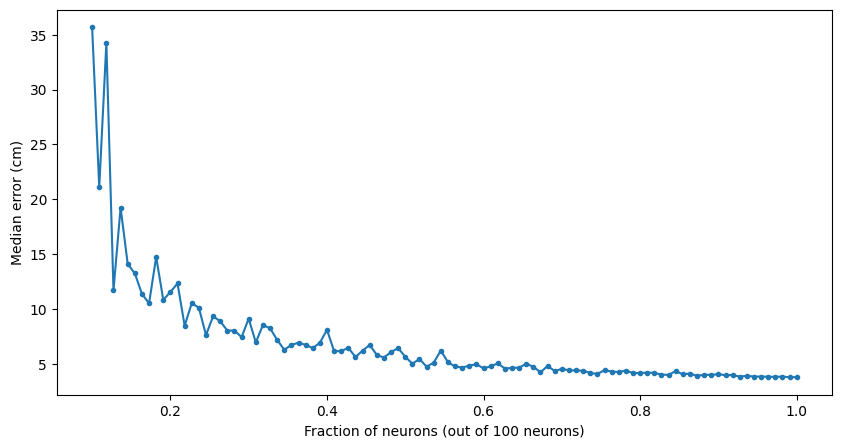

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(sample_frac, errors, '.-')
plt.xlabel('Fraction of neurons (out of 100 neurons)')
plt.ylabel('Median error (cm)')
plt.show()

**C - Noise and decoding**

In [66]:
noises = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
errors = []
for noise in noises:
    with open('data/linear_track_data_noise_{}.pickle'.format(noise), 'rb') as handle:
        data = pickle.load(handle)
    x = data['x']
    t = data['t']
    spikes = data['spikes']
    track_length = data['track_length']
    fps = data['fps']
    true_x = x[:-1]
    spikes_sample = get_random_neurons(spikes, 1)
    x_parallel = decode(x, t, spikes_sample, track_length, fps)
    mse = np.sqrt((true_x-x_parallel)**2)
    errors.append(np.nanmedian(mse))


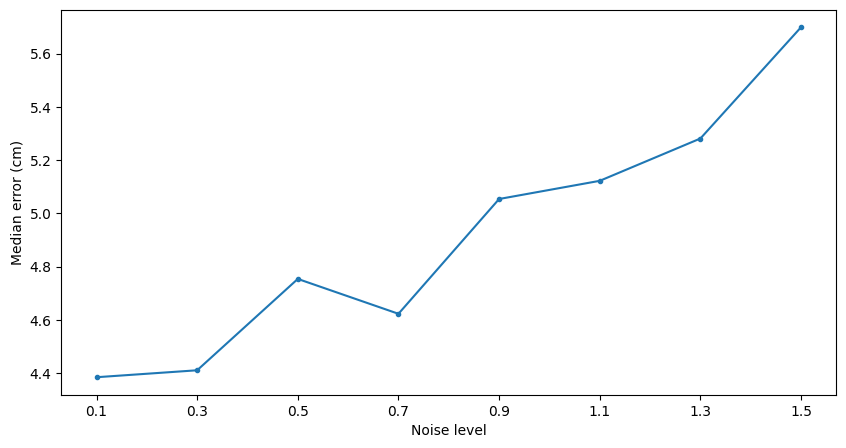

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(noises, errors, '.-')
plt.xlabel('Noise level')
plt.ylabel('Median error (cm)')
plt.xticks(noises)
plt.show()

<div class="alert alert-block alert-info">

**Report for Exercise 1**

A - As I use larger fraction of the dataset, the error decreases, indicating that I obtain more accurate results.

B - Yes, the error seems to converge after around 60 neurons. This might mean at least 60 neurons are needed for accurate decoding.

C - As the noise level goes up, the error increase. Higher noise leads to less accurate decoding results.  

## Exercise 2
---
In the loop implementation of the decoder, we used `poisson.logpmf(k,mu)` to calculate the log probability of observing $k$ spikes given an average firing rate of $\mu$. 
This is mathematically equivalent to `np.log(poisson.pmf(k,mu))`, in which we calculate the probability, and then take the log.


Re-run the decoding substituting this expression:

```
posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
```

To the line we are using to calculate the posterior.
Do you see any difference in the results? What do you think this is due to?




## Exercise 3
---
A - Estimate the quality of the sequence detection methods we saw in the lesson. How many false poistive does it find? How many false negatives?

B - Investigate the effect of `noise_x_react` and `noise_t_react` on the false positive rate and the false negative rate of our detection procedure.

C - What kind of sequence can our methods detect? What kind of activity, despide being sequential, could escape our detection method? Would you have an idea for a different method for sequence detection?


### Code for data generation

In [29]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets


track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

In [30]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [55]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [53]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 1.5 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

In [54]:
import pickle

file_name = 'linear_track_data_noise_1.5.pickle' # change this name when you save new data

out_data = {}
out_data['x'] = x
out_data['t'] = t
out_data['spikes'] = spikes
out_data['track_length'] = track_length
out_data['fps'] = fps

with open('data/'+file_name,'wb') as f:
    pickle.dump(out_data,f)